# SaVi Chatbot

### Install Library

In [7]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from nltk.stem import WordNetLemmatizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model

from urllib import request

import warnings
warnings.filterwarnings("ignore")

'''# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')'''

"# Package sentence tokenizer\nnltk.download('punkt') \n# Package lemmatization\nnltk.download('wordnet')\n# Package multilingual wordnet data\nnltk.download('omw-1.4')"

### Data Acquisition

In [8]:
url = "https://raw.githubusercontent.com/Handepp/Tugas-Akhir-Chatbot/main/Dataset/Data_Wahana.json"
request.urlretrieve(url, "Data_Wahana.json")

('Data_Wahana.json', <http.client.HTTPMessage at 0x28a2e15de50>)

In [9]:
# Importing the dataset
with open('Data_Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [10]:
# Cetak data keseluruhan
data

,patterns,tags
0,Siapa kamu?,SAVI.siapa
1,Kamu siapa?,SAVI.siapa
2,Ini apa?,SAVI.siapa
3,Kamu apa?,SAVI.siapa
4,Robot apakah kamu?,SAVI.siapa
...,...,...
279,Belok ke arah kiri,SAVI.kiri
280,kiri kiri kiri,SAVI.kiri
281,Ke kiri,SAVI.kiri
282,Lihat ke kiri,SAVI.kiri


In [11]:
data.tags.value_counts()

SAVI.siapa          15
SAVI.buruk          12
SAVI.sapa           11
SAVI.benar          10
SAVI.kanan          10
SAVI.stop           10
SAVI.usia           10
SAVI.kiri           10
SAVI.hobby          10
SAVI.asal            9
SAVI.ngobrol         9
SAVI.insaf           9
SAVI.mundur          9
SAVI.maju            9
SAVI.suhu            9
SAVI.hump            9
SAVI.bos             8
SAVI.siap            8
SAVI.tanggal         7
SAVI.Baterai         7
SAVI.fast            7
SAVI.medium          7
SAVI.slow            7
SAVI.beban           7
SAVI.lokasi          7
SAVI.hari            7
SAVI.terimakasih     7
SAVI.bantu           7
SAVI.jam             6
SAVI.berpisah        6
SAVI.baik            5
SAVI.malam           5
SAVI.sore            5
SAVI.pagi            5
SAVI.siang           5
Name: tags, dtype: int64

In [12]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

35 classes ['SAVI.Baterai', 'SAVI.asal', 'SAVI.baik', 'SAVI.bantu', 'SAVI.beban', 'SAVI.benar', 'SAVI.berpisah', 'SAVI.bos', 'SAVI.buruk', 'SAVI.fast', 'SAVI.hari', 'SAVI.hobby', 'SAVI.hump', 'SAVI.insaf', 'SAVI.jam', 'SAVI.kanan', 'SAVI.kiri', 'SAVI.lokasi', 'SAVI.maju', 'SAVI.malam', 'SAVI.medium', 'SAVI.mundur', 'SAVI.ngobrol', 'SAVI.pagi', 'SAVI.sapa', 'SAVI.siang', 'SAVI.siap', 'SAVI.siapa', 'SAVI.slow', 'SAVI.sore', 'SAVI.stop', 'SAVI.suhu', 'SAVI.tanggal', 'SAVI.terimakasih', 'SAVI.usia']


### Preprocessing

In [13]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  #text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [14]:
key= "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv"
request.urlretrieve(key, "key_norm.csv")
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


In [15]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [17]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = stemming(text)
  return text

In [18]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/284 [00:00<?, ?it/s]

CPU times: total: 4.89 s
Wall time: 4.94 s


In [19]:
data

,patterns,tags
0,siapa kamu,SAVI.siapa
1,kamu siapa,SAVI.siapa
2,ini apa,SAVI.siapa
3,kamu apa,SAVI.siapa
4,robot apakah kamu,SAVI.siapa
...,...,...
279,belok ke arah kiri,SAVI.kiri
280,kiri kiri kiri,SAVI.kiri
281,ke kiri,SAVI.kiri
282,lihat ke kiri,SAVI.kiri


## BERT

In [20]:
labelencoder = LabelEncoder()
data['tags'] = labelencoder.fit_transform(data['tags'])

In [21]:
df_train, df_test = train_test_split(data, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.2)

df_train.shape, df_test.shape, df_val.shape

((227, 2), (12, 2), (45, 2))

In [22]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model
vocabulary = bert_tokenizer.get_vocab()

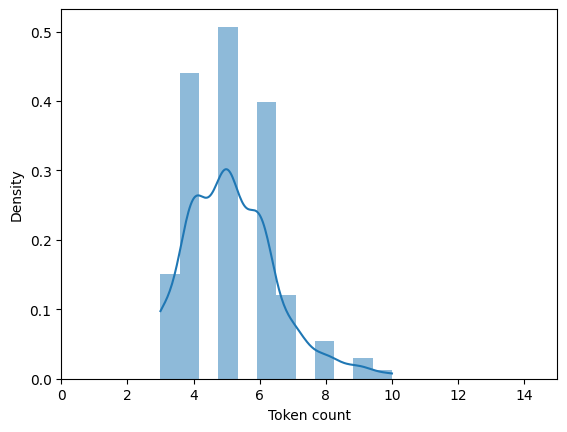

In [23]:
token_lens = []

for txt in data.patterns:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 15]);
plt.xlabel('Token count');

In [24]:
MAX_LEN = 11

In [25]:
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [26]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [27]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [28]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=35)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/20
8/8 [==============================] - 19s 606ms/step - loss: 3.4153 - accuracy: 0.1366 - val_loss: 3.0648 - val_accuracy: 0.3556
Epoch 2/20
8/8 [==============================] - 2s 216ms/step - loss: 2.5753 - accuracy: 0.5419 - val_loss: 2.4342 - val_accuracy: 0.5556
Epoch 3/20
8/8 [==============================] - 2s 220ms/step - loss: 1.9268 - accuracy: 0.7181 - val_loss: 1.9451 - val_accuracy: 0.6444
Epoch 4/20
8/8 [==============================] - 2s 216ms/step - loss: 1.4077 - accuracy: 0.8722 - val_loss: 1.5363 - val_accuracy: 0.7333
Epoch 5/20
8/8 [==============================] - 2s 213ms/step - loss: 1.0050 - accuracy: 0.9207 - val_loss: 1.1634 - val_accuracy: 0.8222
Epoch 6/20
8/8 [==============================] - 2s 215ms/step - loss: 0.6980 - accuracy: 0.9736 - val_loss: 0.8929 - val_accuracy: 0.8444
Epoch 7/20
8/8 [==============================] - 2s 215ms/step - loss: 0.4863 - accuracy: 0.9912 - val_loss: 0.7025 - val_accuracy: 0.9333
Epoch 8/20
8/8 [===

In [30]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

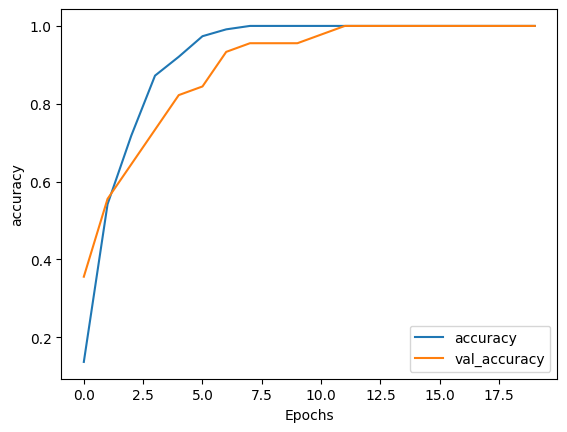

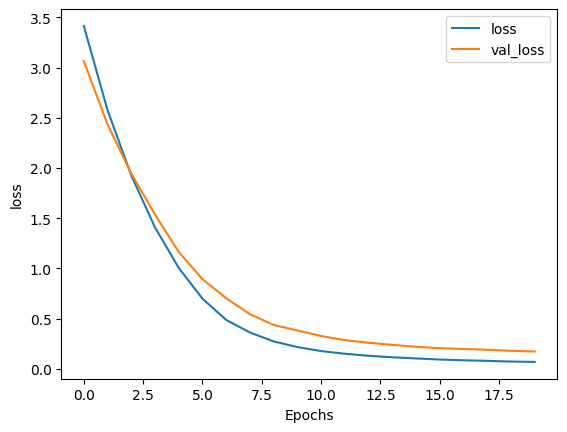

In [31]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [34]:
bert_model.save_weights('Model/bert-SAVI.h5')

In [33]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

1/1 [==============================] - 0s 390ms/step - loss: 0.2085 - accuracy: 1.0000
Test Accuracy: 1.0
